# 删除异常元素 & 质量百分比转化为元素数量比

In [1]:
import csv
import re
import periodictable as pt
from collections import defaultdict

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 计算原子比
def calculate_atomic_ratio(composition, element_mass):
    """计算原子比"""
    total_atom = sum(fraction / element_mass[element] for element, fraction in composition.items())
    return {element: (fraction / element_mass[element]) / total_atom for element, fraction in composition.items()}

# 创建一个空字典来存储元素的原子质量
def create_element_mass_dict():
    """创建元素质量字典"""
    return {element.symbol: element.mass for element in pt.elements}

def standardize_formula(formula):
    """
    标准化化学式，将元素按字母顺序排列，并移除小数值中的多余尾随0（下标为1不省略）。
    """
    composition = parse_formula(formula)
    # sorted_composition = sorted()  # 按元素名排序
    return ''.join(
        f"{element}{('{:.3f}'.format(amount).rstrip('0').rstrip('.'))}"
        for element, amount in composition.items())

def process_csv(input_file, output_file):
    """处理 CSV 文件，解析化学式"""
    element_mass = create_element_mass_dict()  # 元素质量字典
    not_in_mass_count = 0  # 不在周期表的元素
    formulas_with_sum_100 = 0  # 统计下标和为100的分子式数量

    with open(input_file, 'r') as csvfile, open(output_file, 'w', newline='') as new_csvfile:
        reader = csv.DictReader(csvfile)
        formula_column_name = 'formula'  # 替换为实际的化学式列名
        tc_column_name = 'Tc'  # 替换为实际的 Tc 列名

        writer = csv.writer(new_csvfile)
        writer.writerow([formula_column_name, tc_column_name])  # 写入标题行

        for row in reader:
            formula = row[formula_column_name]
            try:
                tc_value = float(row[tc_column_name])
            except ValueError:
                print(f"Invalid Tc value for formula '{formula}': {row[tc_column_name]}")
                continue

            # 标准化化学式
            standardized_formula = standardize_formula(formula)

            # 验证化学式是否有效
            elements_ratios = parse_formula(standardized_formula)
            if all(element in element_mass for element in elements_ratios):
                total_ratio = sum(elements_ratios.values())
                if round(total_ratio, 0) == 100:
                    formulas_with_sum_100 += 1  # 增加下标和为100的分子式计数
                    # 计算原子比
                    atomic_ratios = calculate_atomic_ratio(elements_ratios, element_mass)
                    ratios_str = ''.join(f"{element}{ratio:.3f}" for element, ratio in atomic_ratios.items())
                    standardized_formula = ratios_str  # 用标准化的化学式替换原始分子式
                    # 写入新的CSV文件
                writer.writerow([standardized_formula, f"{tc_value:.3f}"])
            else:
                not_in_mass_count += 1
                print(f"Invalid element for formula '{formula}'")  # 打印非法元素的分子式
                continue
    
    print(f"Number of formulas not in periodictable: {not_in_mass_count}")
    print(f"Number of formulas with sum of subscripts equal to 100: {formulas_with_sum_100}")
    
# 主函数
def main():
    input_file = 'mdr.csv'
    output_file = 'mdr_clean.csv'
    process_csv(input_file, output_file)
if __name__ == "__main__":
    main()
    

Number of formulas not in periodictable: 0
Number of formulas with sum of subscripts equal to 100: 350


# 数据重复度

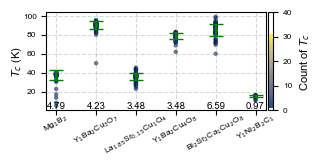

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

# 读取CSV文件
df = pd.read_csv('mdr_duplicated.csv')

# 获取所有不同的formula
formulas = df['formula'].unique()

# 将分子式中的数字和小数转换为下标
def format_formula(formula):
    # 使用正则表达式匹配数字和小数，并将其转换为下标
    return re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)

# 创建一个颜色映射器
vmin = 1  # 最小值可以设置为1，因为计数至少为1
vmax = df['Tc'].value_counts().max()
norm = Normalize(vmin=vmin, vmax=vmax)
original_cmap = plt.cm.cividis  # 使用cividis颜色映射
colors = original_cmap(np.linspace(0, 1, original_cmap.N))  # 获取颜色
colors[:, -1] = colors[:, -1] * 0.8  # 降低透明度
colors[:, :3] *= 1  # 降低亮度
cmap = LinearSegmentedColormap.from_list("user", colors)
sm = ScalarMappable(norm=norm, cmap=cmap)

# 设置图形大小
fig_height = 4.5  #cm
fig_width = 8.5 #cm
plt.rcParams['font.family'] = 'Arial'  # 例如，设置为 Arial 字体
plt.figure(figsize=(fig_width/2.54, fig_height/2.54))

# 为每个formula绘制数据
for formula in formulas:
    # 获取当前formula的数据
    formula_data = df[df['formula'] == formula]
    
    # 计算每个Tc值的出现次数
    tc_counts = formula_data['Tc'].value_counts().to_dict()
    
    # 创建颜色映射，根据Tc值的出现次数来调整颜色深浅
    colors = [cmap(norm(tc_counts[tc])) for tc in formula_data['Tc']]
    
    # 绘制散点图，调整透明度
    plt.scatter([format_formula(formula)] * len(formula_data), formula_data['Tc'], c=colors, label=format_formula(formula), s=5, alpha=0.5)
    
    # 计算平均值和标准差
    mean_tc = formula_data['Tc'].mean()
    std_tc = formula_data['Tc'].std()
    
    # 绘制误差棒
    plt.errorbar(format_formula(formula), mean_tc, yerr=std_tc, fmt='s', color='green', capsize=5, markersize=1,label='Mean ± Std' if formula == formulas[0] else "")

    plt.text(format_formula(formula), 4, f'{std_tc:.2f}', ha='center', va='center', fontsize=7)
    
# 设置图表标题和轴标签
plt.ylabel('$\mathit{T}_{\mathit{c}}$ (K)', fontsize=8, labelpad=-1)
plt.xticks(rotation=30, fontsize=6)  # 确保所有的x轴标签都能显示
plt.tick_params(axis='x', which='major', pad=-2)
plt.yticks(fontsize=6)  # 设置y轴标签的字体大小
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))


# 添加颜色条
cbar = plt.colorbar(sm, orientation='vertical', pad=1e-2)
cbar.set_ticks(np.arange(0, 41, 10))
cbar.ax.tick_params(labelsize=6)
cbar.set_label('Count of $\mathit{T}_{\mathit{c}}$', fontsize=8)

# 添加网格线
plt.grid(True, linestyle='--', color='gray', alpha=0.3)
# 显示图表
plt.tight_layout()
# 保存图表
plt.savefig('../pic/pic/Fig5c_a4.svg',  bbox_inches='tight', transparent=True)
plt.savefig('../pic/pic/Fig5c_a4.tif', dpi=600, bbox_inches='tight', transparent=True)
# 显示图表
plt.show()

# SMOTE过采样

已保存增强后的数据至 mdr_clean_os2.csv


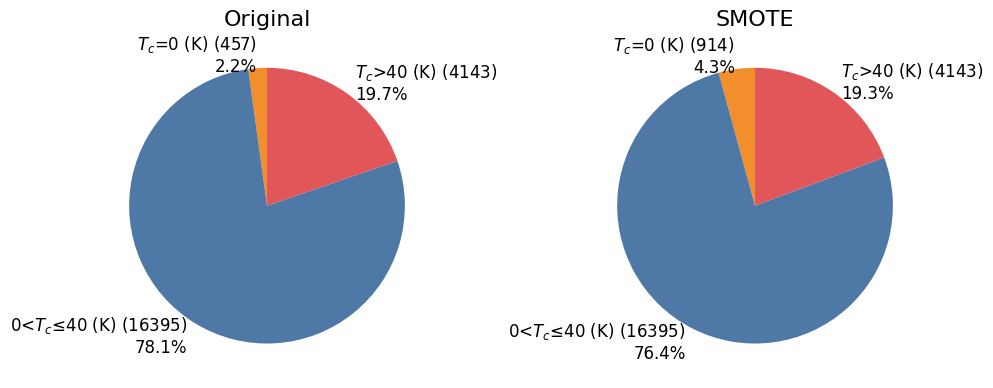

In [11]:
import pandas as pd
import re
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np


# 解析化学式为元素比例字典
def parse_formula(formula):
    elements_ratios = defaultdict(float)
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if ratio == '':
            ratio = 1.0
        else:
            ratio = float(ratio)
        elements_ratios[element] += ratio
    return dict(elements_ratios)

# 将特征向量转换回化学式（近似）
def vector_to_formula(vector, feature_names, threshold=0.1):
    parts = []
    for elem, val in zip(feature_names, vector):
        if val > threshold:
            rounded_val = round(val, 2)
            if rounded_val.is_integer():
                rounded_val = int(rounded_val)
            parts.append(f"{elem}{str(rounded_val) if rounded_val != 1 else ''}")
    return ''.join(parts)

# 主函数执行流程
def main(input_file, output_file):
    # 读取原始数据
    df = pd.read_csv(input_file)

    # 拆分化学式为特征
    parsed_features = [parse_formula(formula) for formula in df['formula']]
    all_elements = set()
    for feat in parsed_features:
        all_elements.update(feat.keys())

    # 构建特征矩阵
    feature_df = pd.DataFrame(parsed_features, columns=sorted(all_elements)).fillna(0)
    X = feature_df.values
    y = np.ceil(df['Tc'].values)

    # 特征标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 设置只对 Tc=0 类别进行过采样
    class_counts = dict(Counter(y))
    current_count_0 = class_counts.get(0, 0)
    desired_count_0 = current_count_0 * 2  

    smote = SMOTE(
        sampling_strategy={0: desired_count_0},
        random_state=42
    )
    X_res, y_res = smote.fit_resample(X_scaled, y)

    # 反向构造化学式
    new_formulas = [vector_to_formula(vec, feature_df.columns) for vec in X_res]

    # 构造新的 DataFrame，并标记来源
    resampled_df = pd.DataFrame({
        'formula': new_formulas,
        'Tc': y_res,
        'type': ['synthetic' if t == 0 else 'original' for t in y_res]
    })

    # 原始数据也加上 type 列
    df['type'] = 'original'


    # 保存结果
    resampled_df.to_csv(output_file, index=False)
    print(f"已保存增强后的数据至 {output_file}")

    # 提取所有类别并排序
    original_counts = dict(Counter(y))
    enhanced_counts = dict(Counter(y_res))

    # 定义三个区间并统计数量
    def count_in_range(counts, condition):
        return sum({k: v for k, v in counts.items() if condition(k)}.values())

    grouped_original = {
        r'$\mathit{T}_{\mathit{c}}$=0 (K)': count_in_range(original_counts, lambda x: x == 0),
        r'0<$\mathit{T}_{\mathit{c}}$≤40 (K)': count_in_range(original_counts, lambda x: 0 < x <= 40),
        r'$\mathit{T}_{\mathit{c}}$>40 (K)': count_in_range(original_counts, lambda x: x > 40)
    }

    grouped_enhanced = {
        r'$\mathit{T}_{\mathit{c}}$=0 (K)': count_in_range(enhanced_counts, lambda x: x == 0),
        r'0<$\mathit{T}_{\mathit{c}}$≤40 (K)': count_in_range(enhanced_counts, lambda x: 0 < x <= 40),
        r'$\mathit{T}_{\mathit{c}}$>40 (K)': count_in_range(enhanced_counts, lambda x: x > 40)
    }

    # 提取标签和数值
    labels = grouped_original.keys()
    original_vals = list(grouped_original.values())
    enhanced_vals = list(grouped_enhanced.values())

    # 辅助函数：生成饼图标签（百分比+数量）
    def make_pie_labels(values):
        total = sum(values)
        return [f'{label} ({val})\n{val / total * 100:.1f}%' for label, val in zip(labels, values)]

    # 设置画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

    # 饼图颜色
    colors = ['#F28E2B','#4E79A7', '#E15759']

    # 原始数据饼图
    ax1.pie(original_vals, labels=make_pie_labels(original_vals), autopct='', colors=colors,
            startangle=90, textprops={'fontsize': 12}) 
    ax1.set_title('Original', fontsize=16)  

    # 增强后数据饼图
    ax2.pie(enhanced_vals, labels=make_pie_labels(enhanced_vals), autopct='', colors=colors,
            startangle=90, textprops={'fontsize': 12}) 
    ax2.set_title('SMOTE', fontsize=16)

    # ==== 单独保存第一个饼图（SMOTE）====
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(original_vals,autopct='', colors=colors,
            startangle=90)
    plt.tight_layout()
    plt.savefig('../pic/pic/Fig6b1_a4.svg',  bbox_inches='tight', transparent=True)
    plt.savefig('../pic/pic/Fig6b1_a4.tif', dpi=600, bbox_inches='tight', transparent=True)
    plt.close(fig1)
    # ==== 单独保存第二个饼图（SMOTE）====
    fig2, ax2 = plt.subplots(figsize=(5, 5))
    ax2.pie(enhanced_vals, autopct='', colors=colors,
            startangle=90)
    plt.tight_layout()
    plt.savefig('../pic/pic/Fig6b2_a4.svg',  bbox_inches='tight', transparent=True)
    plt.savefig('../pic/pic/Fig6b2_a4.tif', dpi=600, bbox_inches='tight', transparent=True)
    plt.close(fig2)
    

    # 自动调整布局
    plt.tight_layout()
    plt.show()

# 程序入口
if __name__ == '__main__':
    input_file = 'mdr_clean_os.csv'     # 输入文件路径
    output_file = 'mdr_clean_os2.csv'   # 输出文件路径
    main(input_file, output_file)

# 删除异常元素 & 质量百分比转化为元素数量比 & 重复分子式求平均

In [1]:
import csv
import re
import periodictable as pt
from collections import defaultdict

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 计算原子比
def calculate_atomic_ratio(composition, element_mass):
    """计算原子比"""
    total_atom = sum(fraction / element_mass[element] for element, fraction in composition.items())
    return {element: (fraction / element_mass[element]) / total_atom for element, fraction in composition.items()}

# 创建一个空字典来存储元素的原子质量
def create_element_mass_dict():
    """创建元素质量字典"""
    return {element.symbol: element.mass for element in pt.elements}

def standardize_formula(formula):
    """
    标准化化学式，将元素按字母顺序排列，并移除小数值中的多余尾随0（下标为1不省略）。
    """
    composition = parse_formula(formula)
    return ''.join(
        f"{element}{('{:.3f}'.format(amount).rstrip('0').rstrip('.'))}"
        for element, amount in composition.items())

def process_csv(input_file, output_file):
    """处理 CSV 文件，解析化学式，计算平均 Tc 值，并记录重复次数"""
    element_mass = create_element_mass_dict()  # 元素质量字典
    formula_data = defaultdict(list)  # 存储每个分子式的 Tc 值
    formula_counts = defaultdict(int)  # 记录每个分子式的重复次数
    not_in_mass_count = 0 # 不在周期表的元素
    formulas_with_sum_100 = 0  # 统计下标和为100的分子式数量

    with open(input_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        formula_column_name = 'formula'  # 替换为实际的化学式列名
        tc_column_name = 'Tc'  # 替换为实际的 Tc 列名

        if formula_column_name not in reader.fieldnames or tc_column_name not in reader.fieldnames:
            print(f"Columns '{formula_column_name}' or '{tc_column_name}' not found in the CSV file.")
            return not_in_mass_count, formula_counts

        for row in reader:
            formula = row[formula_column_name]
            try:
                tc_value = float(row[tc_column_name])
            except ValueError:
                print(f"Invalid Tc value for formula '{formula}': {row[tc_column_name]}")
                continue

            # 标准化化学式
            standardized_formula = standardize_formula(formula)

            # 验证化学式是否有效
            elements_ratios = parse_formula(standardized_formula)
            if all(element in element_mass for element in elements_ratios):
                total_ratio = sum(elements_ratios.values())
                if round(total_ratio, 0) == 100:
                    formulas_with_sum_100 += 1  # 增加下标和为100的分子式计数
                    # 计算原子比
                    atomic_ratios = calculate_atomic_ratio(elements_ratios, element_mass)
                    ratios_str = ''.join(f"{element}{ratio:.3f}" for element, ratio in atomic_ratios.items())
                    standardized_formula = ratios_str  # 用标准化的化学式替换原始分子式
            else:
                not_in_mass_count += 1
                print(f"Invalid element for formula '{formula}'")  # 打印非法元素的分子式
                continue

            # 记录 Tc 值和出现次数
            formula_data[standardized_formula].append(tc_value)
            formula_counts[standardized_formula] += 1

    # 计算每个分子式的 Tc 平均值
    averaged_data = {
        formula: (sum(tc_list) / len(tc_list), formula_counts[formula])
        for formula, tc_list in formula_data.items()
    }

    # 写入新 CSV 文件
    with open(output_file, 'w', newline='') as new_csvfile:
        writer = csv.writer(new_csvfile)
        writer.writerow([formula_column_name, tc_column_name, "count"])  # 标题行
        for formula, (avg_tc, count) in averaged_data.items():
            writer.writerow([formula, f"{avg_tc:.3f}", count])

    return not_in_mass_count, formula_counts, formulas_with_sum_100, not_in_mass_count
    
# 主函数
def main():
    input_file = 'mdr_clean.csv'
    output_file = 'mdr_num.csv'
    not_in_mass_count, formula_counts,formulas_with_sum_100 ,not_in_mass_count = process_csv(input_file, output_file)

    # 统计重复的分子式和重复次数
    repeated_formula_count = sum(1 for count in formula_counts.values() if count > 1)
    total_repeated_data_count = sum(count - 1 for count in formula_counts.values() if count > 1)
    print(f"Number of formulas not in periodictable: {not_in_mass_count}")
    print(f"Number of formulas with sum of subscripts equal to 100: {formulas_with_sum_100}")
    print(f"Number of formulas with duplicates: {repeated_formula_count}")
    print(f"Total number of duplicate data entries: {total_repeated_data_count}")
    print(f"Number of data point: {len(formula_counts)}")
    
if __name__ == "__main__":
    main()
    

Number of formulas not in periodictable: 0
Number of formulas with sum of subscripts equal to 100: 0
Number of formulas with duplicates: 2591
Total number of duplicate data entries: 7021
Number of data point: 13974


# 标记 特殊元素

In [ ]:
import pandas as pd
import re

# 读取CSV文件
df = pd.read_csv('mdr_clean.csv')

# 化学式拆分为字典
def parse_formula(formula):
    elements_ratios = {}
    matches = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    for element, ratio in matches:
        elements_ratios[element] = float(ratio) if ratio else 1.0
    return elements_ratios

# 判断化学式中是否含有非法元素M、D、T
def contains_illegal_elements(formula):
    # 解析化学式
    elements_ratios = parse_formula(formula)
    # 定义非法元素
    illegal_elements = ['M', 'D', 'T']   
    # 检查是否包含非法元素
    for element in illegal_elements:
        if element in elements_ratios:
            return "error"
    return "ok"

# 应用到每一行，添加新的列
df['error'] = df['formula'].apply(contains_illegal_elements)

# 打印结果，检查是否成功添加了"非法"列
print(df)

# 将结果保存为新的CSV文件（可选）
df.to_csv('mdr_with_illegal.csv', index=False)


# 检查 异常元素&下标和100

In [4]:
import csv
import re
import periodictable as pt

# 生成分子式
def generate_formulas(elements, num_formulas):
    formulas = []
    while len(formulas) < num_formulas:
        coefficients = np.random.rand(len(elements))
        coefficients /= coefficients.sum()
        coefficients = np.round(coefficients, 3)
        if np.all(coefficients >= 0) and np.isclose(coefficients.sum(), 1):
            formula = ''.join(f"{elements[i]}{coefficients[i]:.3f}" for i in range(len(elements)) if coefficients[i] != 0)
            formulas.append(formula)
    return formulas

# 创建元素质量字典
def create_element_mass_dict():
    return {element.symbol: element.mass for element in pt.elements}

# 处理CSV文件
def process_csv(input_file):
    element_mass = create_element_mass_dict()
    not_in_mass_count = 0
    formulas_sum_to_100 = []

    with open(input_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  # 跳过标题行
        for row in reader:
            formula = row[0]
            elements_ratios = parse_formula(formula)
            
            if all(element in element_mass for element in elements_ratios):
                total_ratio = sum(elements_ratios.values())
                if round(total_ratio, 2) == 100:
                    formulas_sum_to_100.append(formula)
            else:
                not_in_mass_count += 1

    return not_in_mass_count, formulas_sum_to_100

# 主函数
def main():
    input_file = 'expr.csv'
    not_in_mass_count, formulas_sum_to_100 = process_csv(input_file)

    print(f"Total number of formulas with elements not in element_mass: {not_in_mass_count}")
    if formulas_sum_to_100:
        print("Formulas with sum of subscripts equal to 100:")
        for formula in formulas_sum_to_100:
            print(formula)
    else:
        print("No formulas have a sum of subscripts equal to 100.")

if __name__ == "__main__":
    main()

Total number of formulas with elements not in element_mass: 0
No formulas have a sum of subscripts equal to 100.


# wt转at

In [4]:
import csv
import re
import periodictable as pt

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 计算原子比
def calculate_atomic_ratio(composition, element_mass):
    """计算原子比"""
    total_atom = sum(fraction / element_mass[element] for element, fraction in composition.items())
    return {element: (fraction / element_mass[element]) / total_atom for element, fraction in composition.items()}

# 创建一个空字典来存储元素的原子质量
def create_element_mass_dict():
    """创建元素质量字典"""
    return {element.symbol: element.mass for element in pt.elements}

def standardize_formula(formula):
    """
    标准化化学式，将元素按字母顺序排列，并移除小数值中的多余尾随0（下标为1不省略）。
    """
    composition = parse_formula(formula)
    return ''.join(
        f"{element}{('{:.3f}'.format(amount).rstrip('0').rstrip('.'))}"
        for element, amount in composition.items())

element_mass = create_element_mass_dict()  # 元素质量字典
formula = input('formula:')
# 标准化化学式
standardized_formula = standardize_formula(formula)
# 验证化学式是否有效
elements_ratios = parse_formula(standardized_formula)
atomic_ratios = calculate_atomic_ratio(elements_ratios, element_mass)
ratios_str = ''.join(f"{element}{ratio:.3f}" for element, ratio in atomic_ratios.items())
standardized_formula = ratios_str  # 用标准化的化学式替换原始分子式
print(standardized_formula)

formula:Ga0.78In0.15Sn0.07
Ga0.855In0.100Sn0.045
